#**Машинное обучение ИБ-2024**

#**Домашнее задание 1.**
#Регрессия, KNN, LinearRegression.

В данной домашней работе мы будем строить модели для предсказания цены квартиры в России. Ниже приведено описание некоторых колонок набора данных.

date - дата публикации объявления

price - цена в рублях

level- этаж, на котором находится квартира

levels - количество этажей в квартире

rooms - количество комнат в квартире. Если значение -1, то квартира считается апартаментами.

area - площадь квартиры.

kitchen_area - площадь кухни.

geo_lat - Latitude

geo_lon - Longitude

building_type - материал застройки. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden

#Часть 0. Начало работы

Для начала работы с данными импортируем библиотеки, которые понадобятся в данном задании.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
import seaborn as sns

Загрузим библиотеку folium для отображения данных на карте по координатам.

In [2]:
!pip install folium

Загрузим данные из csv файла в датафрейм.

In [3]:
from google.colab import drive #этот код дал сам колаб, чтоб можно было загрузить файл
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input_data.csv', sep=';') #прописываем путь до файла, sep=';' чтобы данные разбилисть по столбцам а не слиплись в одно

In [5]:
df.dtypes

,0
date,object
price,int64
level,int64
levels,int64
rooms,int64
area,float64
kitchen_area,float64
geo_lat,float64
geo_lon,float64
building_type,int64


Отобразим на карте координаты наших построек.

In [6]:
import folium
from IPython.display import display

map_df = df.loc[:1000]

m = folium.Map(location=[55.751244, 37.618423], zoom_start=10)

# Список точек с широтой и долготой
lats = map_df['geo_lat'].loc[:1000]
longs = map_df['geo_lon'].loc[:1000]
# Добавляем точки на карту
for point in zip(lats, longs):
    folium.Marker(
        location=[point[0], point[1]]
    ).add_to(m)

display(m)

# Часть 1. Подготовим данные для обработки моделями машинного обучения.

**0.5 Балл**. География наших наблюдений в наборе данных крайне большая. Однако мы знаем, что стоимость квартир в Москве и Санкт-Петербурге намного выше, чем в среднем по России. Давайте сделаем признаки, который показывают, находится ли квартира в 20 килиметрах от центра Москвы или находится ли квартира в 20 килиметрах от центра Санкт-Петербурга.

Создайте два признака is_Moscow и is_Saint_Peterburg. Для нахождения расстояния по координатам используйте функцию haversine_distance.

Для определения данных признаков нам нужно подсчитать расстояние между городами, для этого воспользуемся формулой Хаверсина, которая при знании радиуса, широт и долгот поможет рассчитать расстояние между точками сферы. Сама формула имеет следующий вид: 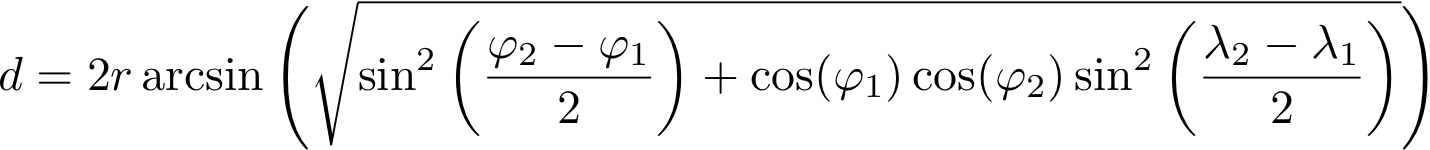

In [7]:
def haversine_distance(lat1, lon1, lat2, lon2):
  r_earth = 6371


  dif_lat = (lat2 - lat1) / (2 * 180 / 3.14)
  dif_lon = (lon2 - lon1) / (2 * 180 / 3.14)

  return 2 * r_earth * np.arcsin(((np.sin(dif_lat) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dif_lon)) ** 2)) ** 0.5)

lat_Moscow = 55.558741
lon_Moscow = 37.378847
lat_Saint_Peterburg = 59.9386
lon_Saint_Peterburg = 30.3141
df['is_Moscow'] = haversine_distance(lat_Moscow, lon_Moscow, df['geo_lat'], df['geo_lon']) < 20
df['is_Saint_Peterburg'] = haversine_distance(lat_Saint_Peterburg, lon_Saint_Peterburg, df['geo_lat'], df['geo_lon']) < 20

**0.5 Балла**. В нашем наборе данных есть признаки, которые мы теоретически можем использовать, например postal_code, но мы это будем делать в рамках домашней работы очень-очень долго. Поэтому предлагается удалить ненужные признаки из датафрейма.

Удалим geo_lat,	geo_lon,	object_type,	postal_code,	street_id,	id_region,	house_id.

In [8]:
df.drop(['geo_lat',
         'geo_lon',
         'object_type',
         'postal_code',
         'street_id',
         'id_region',
         'house_id'], axis=1, inplace=True)

In [9]:
df.columns.tolist()

['date',
 'price',
 'level',
 'levels',
 'rooms',
 'area',
 'kitchen_area',
 'building_type',
 'is_Moscow',
 'is_Saint_Peterburg']

**0.5 Балл**. Для начала Вам предлагается проанализировать Ваши оставшиеся признаки (колонки) в наборе данных. Какие колонки категориальные? Какие числовые?

Категориальные: building_type, is_Moscow, is_Saint_Peterburg

Числовые: date, price, level, levels, rooms, area, kitchen_area

Давайте закодируем категориальные признаки с помощью OneHot-Encoding. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [10]:
from sklearn.preprocessing import OneHotEncoder
a = OneHotEncoder(sparse_output = False)

Прописываем наши категориальные признаки, OneHotEncoder возьмет каждую колонку и выделит в ней свои категории. Он это делает это так: у признака несколько категорий и значение каждой категории может быть 0 и 1, 1 в случае если сейчас данная категория, а 0 если нет. То есть для одного признака в строке только 1 единица и несколько 0.

In [11]:
df_enc = pd.DataFrame(a.fit_transform(df[['building_type', 'is_Moscow', 'is_Saint_Peterburg']]))
df_enc

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11358145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358146,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [12]:
df_enc.columns = a.get_feature_names_out()

In [13]:
df = df.join(df_enc)
df.drop(['building_type', 'is_Moscow', 'is_Saint_Peterburg'], axis = 1, inplace = True)
df

,date,price,level,levels,rooms,area,kitchen_area,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,is_Moscow_False,is_Moscow_True,is_Saint_Peterburg_False,is_Saint_Peterburg_True
0,2021-01-01,2451300,15,31,1,30.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2021-01-01,10700000,4,13,3,85.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2021-01-01,2500000,2,3,1,30.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358145,2021-12-31,6099000,4,9,3,65.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358146,2021-12-31,2490000,1,10,2,56.9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358147,2021-12-31,850000,2,2,2,37.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11358148,2021-12-31,4360000,5,5,1,36.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


**0.5 Балл**. Поработаем с числовыми признаками:


1.   Добавьте в ваш датасет два признака: количество дней со дня первого наблюдения (разница между датами объявлений). Возможно, для предсказания цены не так важен этаж, как важно отношение этажа квартиры на количество этажей в доме, добавьте этот признак. После добавления нового признака колонку date можно удалить.
2.   Числовые признаки могут иметь разные порядки. Давайте отнормируем числовые признаки с помощью StandartScaller https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.



In [14]:
date_min = pd.to_datetime(df['date'].min()) # берем минимальную дату

In [15]:
unique_level = df['level'].unique() #проверим какие значения этажей есть, так как мы делим на это число и нам важно чтобы деление было валидным
print(unique_level)

[15  5  4  3  2  1 16  8 19 10  6 11  9  7 12 20 13 17 21 32 14 24 23 26
 25 18 22 34 27 28 31 33 30 29 46 44 35  0 36 45 37 38 39 40 50 41 42 43
 47 48 49]


In [16]:
unique_levels = df['levels'].unique()
print(unique_levels)

[31  5 13  3  4  2 18 19  9 17 20  7  6 22 29 14  8 10 16  1 25 11 12 21
 24 33 42 15 32 26 23 27 47 34 39 28 41 38 30 36 35 40 44 37 46 43 45 48
 49 50  0]


У нас есть 0 этаж, значит при тупом делении количества этажей на этаж квартиры мы у некоторых строк получим бесконечные значения, что в будущем нам помешает отнормировать их.
Я использую следующую логику: если квартира на 0 этаже, то прибавляем 1 и к этажу и к общему количеству этажей. Например:
Квартира на 0 этаже, а в доме 10. Грубо говоря мы будем вести отсчёт квартир с 0 этажа и получим отношение (10+1)/1=11

In [17]:
df['date'] = pd.to_datetime(df['date'])
df['date_dif'] = (df['date'] - date_min).dt.days
df['level_ratio'] = np.where(
    df['level'] == 0,
    df['levels'] + 1,  # если этаж = 0
    df['levels'] / df['level']  # если этаж != 0
)

In [18]:
df.drop('date', axis = 1, inplace = True) #удаляем столбец даты

In [19]:
df #проверяем, что столбцы добавились и в них адекватные значения

,price,level,levels,rooms,area,kitchen_area,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,is_Moscow_False,is_Moscow_True,is_Saint_Peterburg_False,is_Saint_Peterburg_True,date_dif,level_ratio
0,2451300,15,31,1,30.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,2.066667
1,1450000,5,5,1,33.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1.000000
2,10700000,4,13,3,85.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,3.250000
3,3100000,3,5,3,82.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1.666667
4,2500000,2,3,1,30.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358145,6099000,4,9,3,65.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,364,2.250000
11358146,2490000,1,10,2,56.9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,364,10.000000
11358147,850000,2,2,2,37.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,364,1.000000
11358148,4360000,5,5,1,36.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,364,1.000000


Отнормировываем числовые признаки

In [20]:
from sklearn.preprocessing import StandardScaler

colm = ['price', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'level_ratio', 'date_dif']
scaler = StandardScaler()
df[colm] = scaler.fit_transform(df[colm])
df

,price,level,levels,rooms,area,kitchen_area,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,is_Moscow_False,is_Moscow_True,is_Saint_Peterburg_False,is_Saint_Peterburg_True,date_dif,level_ratio
0,-0.021932,1.622769,2.665027,-0.621470,-0.840577,0.082486,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,-0.254885
1,-0.026996,-0.270043,-0.936859,-0.621470,-0.741051,0.267565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,-0.643390
2,0.019789,-0.459324,0.171414,1.106234,1.175756,0.452644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,0.176113
3,-0.018651,-0.648605,-0.936859,1.106234,1.065171,0.360105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,-0.400574
4,-0.021686,-0.837886,-1.213927,-0.621470,-0.851636,0.360105,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.858355,-0.461278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358145,-0.003482,-0.459324,-0.382722,1.106234,0.438523,0.082486,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,-0.188111
11358146,-0.021736,-1.027168,-0.244188,0.242382,0.139943,0.082486,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,2.634621
11358147,-0.030031,-0.837886,-1.352461,0.242382,-0.593604,0.236719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,-0.643390
11358148,-0.012278,-0.270043,-0.936859,-0.621470,-0.630466,0.360105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.752639,-0.643390


**2 Балла**. Реализуйте класс KNNRegressor, который должен делать регрессию методом k ближайших соседей.

В методе init указываются два параметра: n_neighbors (количество соседей) и distance_func (функция расстояния). По умолчанию n_neighbors = 5, а функция расстояния — евклидова (модуль euclidean нужен, чтобы подключить эту функцию).
Метод fit просто сохраняет обучающие данные X и целевые значения y внутри объекта, чтобы использовать их позже. Он возвращает self, то есть сам объект модели.
Дальше идёт метод predict, который и делает основную работу. Он получает тестовые точки X_t и создаёт массив для хранения предсказаний. Затем для каждой точки в X_t я считаю расстояние до всех точек обучающей выборки с помощью евклидовой метрики. После этого я сортирую эти расстояния с помощью np.argsort — эта функция возвращает индексы отсортированных значений. Мне как раз нужны индексы, чтобы взять нужные целевые значения соседей.
Из отсортированного списка я беру первые k соседей, сохраняю их целевые значения в neighbors_prediction и cчитаю среднее значение с помощью np.mean и записывает его как предсказание.

In [21]:
from scipy.spatial.distance import euclidean

class KNNRegressor:
    def __init__(self, n_neighbors=5, metric=euclidean):
      self.n_neighbors = n_neighbors
      self.metric = metric

    def fit(self, X, y):
      self.X = X
      self.y = y
      return self

    def predict(self, X_t):
      Y_pr = np.empty(X_t.shape[0])
      for index, entry in enumerate(X_t):
        distances = [self.metric(i, entry) for i in self.X]
        neighbors = np.argsort(distances)[: self.n_neighbors]
        neighbors_prediction = [self.y[j] for j in neighbors]
        Y_pr[index] = np.mean(neighbors_prediction)
      return Y_pr

**3 Балла**. Реализуйте класс LinearRegression, поддерживающий обучение градиентными спусками SGD, Momentum, AdaGrad. Используйте градиент для оптимизации функции потерь MSE.

В методе init лежат основные параметры:
learning_rate определяет насколько сильно обновляются веса на каждом шаге; optimization это какой метод оптимизации мы берем; epsilon число, которое лежит в знаменателе AdaGrad (чтобы не было деления на 0); decay_rate коэффициент затухания для Momentum; max_iter количество итераций обучения; weights и bias параметры модели (веса и смещение), которые будут подбираться в процессе обучения.
Метод fit обучает модель. Сначала сохраняю количество образцов и признаков.Затем инициализирую веса нулями, а смещение bias равным 0.
v_w и v_b это для Momentum (хранят скопленное «ускорение»), а g_w и g_b для AdaGrad (накапливают квадраты градиентов).
Далее идет цикл обучения на max_iter итераций: вычисляются предсказания y_pred как скалярное произведение X @ weights + bias. Нахожу градиенты по весам и смещению grad_w и grad_b — это производные функции ошибки MSE.
До этого всё было одинаково для всех 3 методов, сейчас в зависимости от выбранного метода обновления весов меняется поведение. Для SGD просто двигаю веса в сторону уменьшения ошибки на шаг learning_rate, для Momentum добавляю момент за счёт накопления прошлых градиентов, для AdaGrad корректирую скорость обучения для каждого веса индивидуально, уменьшая шаг при накоплении градиента.
Метод predict делает предсказания. Умножаем признаки на обученные веса и добавляем смещение.


In [22]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, optimization='SGD', epsilon=1e-8, decay_rate=0.9, max_iter=1000):
        self.learning_rate = learning_rate
        self.optimization = optimization
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        v_w = np.zeros_like(self.weights)
        v_b = 0
        g_w = np.zeros_like(self.weights)
        g_b = 0
        for _ in range(self.max_iter):
            y_pred = X @ self.weights + self.bias
            error = y_pred - y

            grad_w = (2 / n_samples) * (X.T @ error)
            grad_b = (2 / n_samples) * np.sum(error)

            if self.optimization == 'SGD':
                self.weights -= self.learning_rate * grad_w
                self.bias -= self.learning_rate * grad_b

            elif self.optimization == 'Momentum':
                v_w = self.decay_rate * v_w + self.learning_rate * grad_w
                v_b = self.decay_rate * v_b + self.learning_rate * grad_b
                self.weights -= v_w
                self.bias -= v_b

            elif self.optimization == 'AdaGrad':
                g_w += grad_w ** 2
                g_b += grad_b ** 2
                self.weights -= (self.learning_rate / (np.sqrt(g_w) + self.epsilon)) * grad_w
                self.bias -= (self.learning_rate / (np.sqrt(g_b) + self.epsilon)) * grad_b

        return self
    def predict(self, X):
        return X @ self.weights + self.bias

# Часть 2. Эксперименты с моделями машинного обучения.

**3 Балла**. Проведите эксперименты с написанными Вами методами машинного обучения. Выделите обучающую и тестовую выборки в отношении 0,8 и 0,2 соответственно. Измерьте ошибку MSE, MAE, RMSE. Заиспользуйте методы KNNRegressor и LinearRegression из библиотеки sklearn, сравните качество Ваших решений и библиотечных.

Так как у KNN очень долгое время работы, то будем брать рандомную подвыборку из всего датафрейма и на ней считать наши эксперименты.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
df_copy = df.sample(1000).copy()
results = []

X = df_copy.drop(columns=['price']).values
y = df_copy['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

knn = KNNRegressor().fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_ck = mean_squared_error(y_test, y_pred_knn)
mae_ck = mean_absolute_error(y_test, y_pred_knn)
rmse_ck = np.sqrt(mse_ck)
results.append(('custom_KNN_k5', mse_ck, mae_ck, rmse_ck))

lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_clr = mean_squared_error(y_test, y_pred_lr)
mae_clr = mean_absolute_error(y_test, y_pred_lr)
rmse_clr = np.sqrt(mse_clr)
results.append(('custom_Linear_SGD', mse_clr, mae_clr, rmse_clr))

res_df = pd.DataFrame(results, columns=['model', 'MSE', 'MAE', 'RMSE'])
print(res_df.to_string(index=False))

            model      MSE      MAE     RMSE
    custom_KNN_k5 0.000985 0.014694 0.031389
custom_Linear_SGD 0.001000 0.019083 0.031630


In [24]:
from sklearn.neighbors import KNeighborsRegressor as SKKNN
from sklearn.linear_model import LinearRegression as SKLinear


sk_knn = SKKNN().fit(X_train, y_train)
y_pred_sk_knn = sk_knn.predict(X_test)
mse_skn = mean_squared_error(y_test, y_pred_sk_knn)
mae_skn = mean_absolute_error(y_test, y_pred_sk_knn)
rmse_skn = np.sqrt(mse_skn)
results.append(('sklearn_KNN', mse_skn, mae_skn, rmse_skn))

sk_lr = SKLinear().fit(X_train, y_train)
y_pred_sk_lr = sk_lr.predict(X_test)
mse_slr = mean_squared_error(y_test, y_pred_sk_lr)
mae_slr = mean_absolute_error(y_test, y_pred_sk_lr)
rmse_slr = np.sqrt(mse_slr)
results.append(('sklearn_Linear', mse_slr, mae_slr, rmse_slr))
res_df = pd.DataFrame(results, columns=['model', 'MSE', 'MAE', 'RMSE'])
print(res_df.to_string(index=False))

            model      MSE      MAE     RMSE
    custom_KNN_k5 0.000985 0.014694 0.031389
custom_Linear_SGD 0.001000 0.019083 0.031630
      sklearn_KNN 0.000985 0.014694 0.031389
   sklearn_Linear 0.001009 0.019140 0.031769


Мы видим, что наши ошибки очень близки к библиотечным (а у KNN совсем совпадают), что говорит о правильной реализации методов обучения.